# Semantic Segmentation of Urban Aerial Images Using U-Net

Author: **Marcin Sikorski**<br>
Date: August, 2024

**Introduction & Motivation**<br>
Satellite and aerial imagery provide a unique bird's-eye view of the Earth's surface, allowing us to study and map the ground with detail, breadth and regular repeat coverage. Analyzing these images to extract meaningful information is the domain of satellite image analysis and remote sensing. A core technique in this field is image segmentation. This is the process of clustering parts of an image together based on similarity. Image segmentation allows us to locate and delineate objects or regions of interest within aerial images. Over the past decades, researchers have been developing automated segmentation methods to efficiently analyze massive volumes of satellite data for applications like: environmental monitoring, ecosystem engineering, disaster response, remote sensing, urban planning, and land use mapping.

Satellite image segmentation has progressed remarkably from early spectral classification. The digital revolution and latest years of development of advanced machine learning algorithms (especially artificial neural networks) demonstrate less and less need for analog photo interpretation, which is time-consuming and limited by the analyst's subjective judgment. Modern classification techniques rely heavily on deep learning models. They compare pixel spectral signatures to training data from known cover types to assign each pixel to a class like water, vegetation, or urban. Resulting thematic maps effectively segmented the landscape into class-based regions. Accuracy assessment using ground reference data allowed refinement of classes.

The objective of this notebook is to perform such semantic segmentation on aerial images of Dubai in UAE. To complete the task we will implement the U-Net model. The data that we will be working with comes from [Kaggle](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery). The dataset has two sorts of files: actual aerial photographs obtained by MBRSC satellites in JPG format and masked images of those files in PNG format (annotated with pixel-wise semantic segmentation in six classes).

**Notebook Content:**
1. Loading & Preprocessing Data
2. Plotting the Dataset
3. Setting Categorical Labels & Splitting Data
4. U-Net Architecture & Model Training
5. U-Net Evaluation
6. Conclusions

### 1. Loading & Preprocessing Data

At this stage, we will load the fundamental data (satellite images and their corresponding masks). For both images and masks the following steps will be taken:
* unzip data into new directory;
* load, resize, crop, and extract (256 x 256 x 3) patches from each image;
* rescale the new patches (normalize matrix features);
* convert final datasets into NumPy arrays.

The resulting arrays will have elements corresponding to each other in order - image vs. mask.

In [1]:
import zipfile
from pathlib import Path
import os

# setup path to data folder
image_path = Path('segmentation_data/')

if image_path.is_dir():
    print(f'The {image_path} directory already exists')
else:
    image_path.mkdir(parents=True, exist_ok=True)
    # unzip file
    with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
        print('Unzipping data...')
        zip_ref.extractall(image_path)
        print('Done')

Unzipping data...
Done


In [2]:
#pip install patchify
#pip install opencv-python
#pip install -U segmentation-models
import cv2
import numpy as np
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

patch_size = 256
scaler = MinMaxScaler(feature_range=(0, 1))

# dataset of images
image_dataset = []

for path, subdirs, files in os.walk('segmentation_data/'):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith('.jpg'):
                image = cv2.imread(path + '/' + image_name, 1)
                x_size = (image.shape[1] // patch_size)*patch_size
                y_size = (image.shape[0] // patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, x_size, y_size))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i, j, 0, :, :]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [3]:
# dataset of masks
mask_dataset = []

for path, subdirs, files in os.walk('segmentation_data/'):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith('.png'):
                mask = cv2.imread(path + '/' + mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                x_size = (mask.shape[1] // patch_size)*patch_size
                y_size = (mask.shape[0] // patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0, 0, x_size, y_size))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i, j, 0, :, :]
                        mask_dataset.append(single_patch_mask)

In [4]:
# convert lists to NumPy arrays
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

### 2. Plotting the Dataset

A few samples of the patches and their masks will be generated.

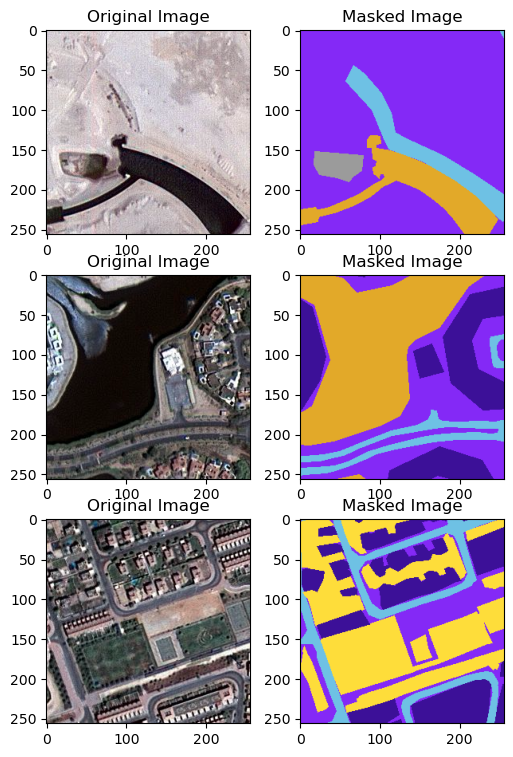

In [5]:
from random import randint

# visualize randoms images & their masks
def generate_dataset():
    fig, axs = plt.subplots(3, 2, figsize=(6, 9))
    
    rand_number = randint(0, len(image_dataset))
    axs[0, 0].imshow(image_dataset[rand_number])
    axs[0, 0].set(title='Original Image')
    axs[0, 1].imshow(mask_dataset[rand_number])
    axs[0, 1].set(title='Masked Image')
    
    rand_number = randint(0, len(image_dataset))
    axs[1, 0].imshow(image_dataset[rand_number])
    axs[1, 0].set(title='Original Image')
    axs[1, 1].imshow(mask_dataset[rand_number])
    axs[1, 1].set(title='Masked Image')
                  
    rand_number = randint(0, len(image_dataset))
    axs[2, 0].imshow(image_dataset[rand_number])
    axs[2, 0].set(title='Original Image')
    axs[2, 1].imshow(mask_dataset[rand_number])
    axs[2, 1].set(title='Masked Image')
    
    plt.show()

generate_dataset()

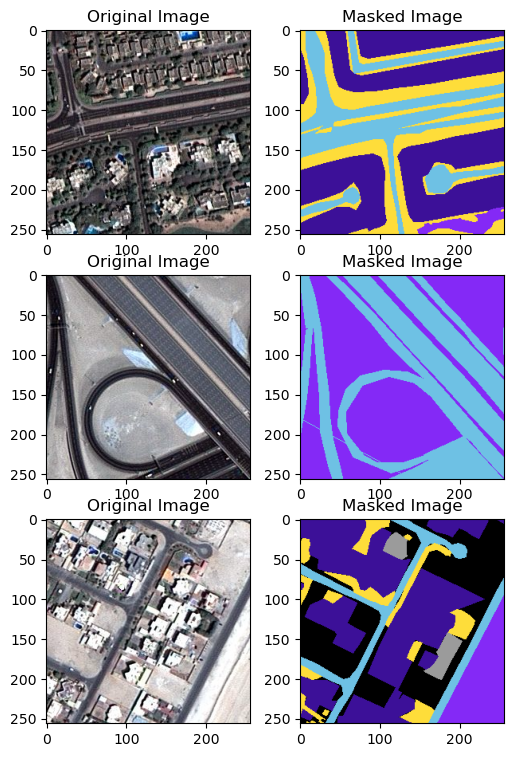

In [6]:
generate_dataset()

### 3. Setting Categorical Labels & Splitting Data

The class colors are in hexadecimal numerical system and the mask images are in RGB. We need to convert the original masks in RGB and encode the output as integers for multi-class classification tasks. Next step will be to convert class integers to binary class matrix. Finally, we will split the data into training and validation subsets with 80:20 ratio. The six classes are:

1. Building: #3C1098
2. Land (unpaved area): #8429F6
3. Road: #6EC1E4
4. Vegetation: #FEDD3A
5. Water: #E2A929
6. Unlabeled: #9B9B9B

In [7]:
# convert Hex to RGB array
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # (60, 16, 152)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) # (132, 41, 246)

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) # (110, 193, 228)

Vegetation =  '#FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) # (254, 221, 58)

Water = '#E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) # (226, 169, 41)

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) # (155, 155, 155)

print(f'Building: {Building}\nLand: {Land}\nRoad: {Road}\nVegetation: {Vegetation}\nWater: {Water}\nUnlabeled: {Unlabeled}')

Building: [ 60  16 152]
Land: [132  41 246]
Road: [110 193 228]
Vegetation: [254 221  58]
Water: [226 169  41]
Unlabeled: [155 155 155]


In [8]:
label = single_patch_mask

def rgb_to_2d_labels(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis=-1)] = 0
    label_seg [np.all(label == Land, axis=-1)] = 1
    label_seg [np.all(label == Road, axis=-1)] = 2  
    label_seg [np.all(label == Vegetation, axis=-1)] = 3   
    label_seg [np.all(label == Water, axis=-1)] = 4
    label_seg [np.all(label == Building, axis=-1)] = 5
    
    label_seg = label_seg[:, :, 0]
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2d_labels(mask_dataset[i])
    labels.append(label)

# convert to NumPy array & expand the shape
labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 
print('Unique labels in label dataset:', np.unique(labels))

Unique labels in label dataset: [0 1 2 3 4 5]


In [9]:
from tensorflow.keras.utils import to_categorical

# convert class integers to binary class matrix
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

print('Labels shape:', labels_cat.shape)

Labels shape: (1305, 256, 256, 6)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.20, random_state=42)

print('Training samples:', len(X_train))
print('Testing samples:', len(X_test))

Training samples: 1044
Testing samples: 261


### 4. U-Net Architecture & Model Training

The U-Net is a convolutional network architecture designed originally for fast and precise segmentation of biomedical images. It was introduced in this [paper](https://arxiv.org/pdf/1505.04597). The network will consist two parts for the model: contracting path (encoder) and expansive path (decoder). We will do some modifications and add padded convolutions. The contraction path is to understand the image until the model reaches the bottom. The expansive path is to locate the area where the model needs to show the segmented area. For this, the same architecture will be used of the encoder but instead of using max pooling, we will be using deconvolution layers with concatenate layers. At the end of the decoder, we will use one CNN layer with softmax as activation for getting the output image from the model.

For tasks related to semantic segmentation, we will implement commonly used evaluation metrics which score the similarity between the predicted (prediction) and annotated segmentation (ground truth). These metrics are: Jaccard index (or Intersection over Union or Jaccard similarity coefficient) and Dice coefficient (also called F1-score or Dice-Sørensen index). The difference between the two metrics is that the IoU penalizes under- and over-segmentation more than Dice. Both scores range from 0 to 1.

$$IoU = \frac{\text{Area of overlap}}{\text{Area of union}} = \frac{|A \cap B|}{|A \cup B|} = \frac{TP}{TP + FP + FN}$$

$$Dice = \frac{2 \times \text{Area of overlap}}{\text{Total area}} = \frac{2|A \cap B|}{|A| + |B|} = \frac{TP + TP}{TP + TP + FP + FN} = \frac{2 IoU}{IoU + 1}$$

For a multiclass segmentation we need to define a loss function. The loss should improve minority label classification. Using the segmentation models library we will describe the total loss for the U-Net as following summation. The Dice loss will include class weights in which all will be equal. The $\lambda$ in the equation is constant and by default will be equal 1 meaning no factors will involve the Focal loss.

$$\text{total loss} = \text{Dice loss} + (\lambda \times \text{Focal loss})$$

In [11]:
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import MeanIoU

# Jaccard coefficient
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Dice coefficient
def dice_coef(y_true, y_pred):
    return (2.0 * K.sum(y_true * y_pred) + 1.0) / (K.sum(y_true) + K.sum(y_pred) + 1.0)

'''
# mean Intersection over Union
class CustomMeanIoU(MeanIoU):
    # source: https://github.com/tensorflow/tensorflow/issues/32875#issuecomment-707316950
    
    def __init__(self, num_classes=None, name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.math.argmax(y_true, axis=-1)
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
'''

'\n# mean Intersection over Union\nclass CustomMeanIoU(MeanIoU):\n    # source: https://github.com/tensorflow/tensorflow/issues/32875#issuecomment-707316950\n    \n    def __init__(self, num_classes=None, name=None, dtype=None):\n        super(CustomMeanIoU, self).__init__(\n            num_classes=num_classes, name=name, dtype=dtype)\n\n    def update_state(self, y_true, y_pred, sample_weight=None):\n        y_true = tf.math.argmax(y_true, axis=-1)\n        y_pred = tf.math.argmax(y_pred, axis=-1)\n        return super().update_state(y_true, y_pred, sample_weight)\n'

In [12]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

# define total loss
# each class will have the same weight (1.0 : 6 = 1.6666)
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) 

Segmentation Models: using `tf.keras` framework.


In [13]:
# clear previous session
#K.clear_session()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, concatenate
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, UpSampling2D, Lambda
from tensorflow.keras.optimizers import Adam

def unet_model(num_classes=6, img_height=256, img_width=256, img_channels=3):

    inputs = Input((img_height, img_width, img_channels))

    # contraction path (encoder)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # expansive path (decoder)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs], name='U-Net')    
    return model
    
# evaluation metrics
#custom_mIoU_metric = CustomMeanIoU(num_classes=6, name='mIoU', dtype=None)
metrics = ['accuracy', jaccard_index, dice_coef]

def create_model():
    return unet_model(num_classes=len(np.unique(labels)),
                      img_height=X_train.shape[1],
                      img_width=X_train.shape[2],
                      img_channels=X_train.shape[3])

unet_model = create_model()

unet_model.compile(optimizer=Adam(learning_rate=0.001, name='adam'), loss=total_loss, metrics=metrics)

# display U-Net architecture
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.saving import save_model

# set callbacks
csv_logger = CSVLogger('unet_history.txt', append=True, separator=',')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=12,
                          mode='auto',
                          verbose=1,
                          restore_best_weights=True)

checkpoint = ModelCheckpoint('UNet_segmentation.weights.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='auto',
                             verbose=1,
                             save_weights_only=True)

# train U-Net model
unet_history = unet_model.fit(X_train, y_train,
                              batch_size=16,
                              verbose=1,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              shuffle=False,
                              callbacks=[csv_logger, earlystop])

# save model
save_model(unet_model, 'UNet_segmentation.keras')

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.3096 - dice_coef: 0.2428 - jaccard_index: 0.1428 - loss: 1.0226 - val_accuracy: 0.5777 - val_dice_coef: 0.4999 - val_jaccard_index: 0.3371 - val_loss: 0.9870
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.6023 - dice_coef: 0.5127 - jaccard_index: 0.3473 - loss: 0.9835 - val_accuracy: 0.7014 - val_dice_coef: 0.6067 - val_jaccard_index: 0.4389 - val_loss: 0.9612
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.6878 - dice_coef: 0.6073 - jaccard_index: 0.4383 - loss: 0.9640 - val_accuracy: 0.7492 - val_dice_coef: 0.6534 - val_jaccard_index: 0.4889 - val_loss: 0.9498
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.7382 - dice_coef: 0.6568 - jaccard_index: 0.4906 - loss: 0.9511 - val_accuracy: 0.7409 - val_dice_coef: 0.6602 - val_jaccard_index: 0.4971 - val_loss: 0.9502
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.7623 - dice_coef: 0.6894 - jaccard_ind

In [15]:
from pandas import DataFrame

# display training results
df_results = DataFrame(unet_history.history)
df_results.round(4)

,accuracy,dice_coef,jaccard_index,loss,val_accuracy,val_dice_coef,val_jaccard_index,val_loss
0,0.4408,0.3465,0.2171,1.0070,0.5777,0.4999,0.3371,0.9870
1,0.6323,0.5380,0.3707,0.9768,0.7014,0.6067,0.4389,0.9612
2,0.7066,0.6162,0.4477,0.9596,0.7492,0.6534,0.4889,0.9498
3,0.7422,0.6612,0.4959,0.9490,0.7409,0.6602,0.4971,0.9502
4,0.7716,0.7060,0.5480,0.9402,0.7655,0.7058,0.5504,0.9409
5,0.7892,0.7343,0.5820,0.9336,0.7689,0.7223,0.5707,0.9402
6,0.7960,0.7437,0.5937,0.9307,0.7636,0.7110,0.5568,0.9409
7,0.7998,0.7471,0.5981,0.9287,0.7898,0.7401,0.5923,0.9316
8,0.8068,0.7553,0.6083,0.9260,0.7894,0.7418,0.5945,0.9311
9,0.8097,0.7580,0.6120,0.9246,0.7966,0.7525,0.6085,0.9288


### 5. U-Net Evaluation

The model has been trained and its performance will be evaluated. We will plot the learning curves for loss and IoU (Jaccard index) to get an overall review of the learning process. Next, basic metrics will be computed and finally sample predictions will be performed.

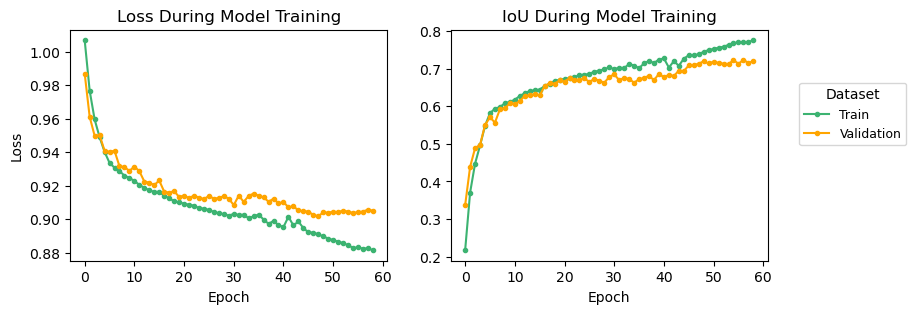

In [16]:
# plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

ax[0].plot(unet_history.history['loss'], color='mediumseagreen', marker='.', label='Train')
ax[0].plot(unet_history.history['val_loss'], color='orange', marker='.', label='Validation')
ax[0].set(title='Loss During Model Training', xlabel='Epoch', ylabel='Loss')

ax[1].plot(unet_history.history['jaccard_index'], color='mediumseagreen', marker='.', label='Train')
ax[1].plot(unet_history.history['val_jaccard_index'], color='orange', marker='.', label='Validation')
ax[1].set(title='IoU During Model Training', xlabel='Epoch', ylabel=None)
ax[1].legend(loc=(1.1, 0.5), prop={'size': 9}, title='Dataset')

plt.show()

The deep learning model behavior is characterized by slight overfitting - training dataset is improved at the cost of worse performance on data not seen during training.

In [17]:
from tensorflow.keras.metrics import IoU, Accuracy

# evaluation metrics - built-in functions
y_pred = unet_model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# 1. IoU
IoU_keras = IoU(num_classes=6, target_class_ids=[0, 1, 2, 3, 4, 5])  
IoU_keras.update_state(y_test_argmax, y_pred_argmax)
IoU_metric = IoU_keras.result().numpy()

# 2. Dice
dice_metric = (2 * IoU_metric)/(IoU_metric + 1)

# 3. accuracy
acc_keras = Accuracy()  
acc_keras.update_state(y_test_argmax, y_pred_argmax)
acc_metic = acc_keras.result().numpy()

print('\n*********Evaluation Metrics*********')
print('IoU:', IoU_metric.round(6))
print('Dice:', dice_metric.round(6))
print('Accuracy:', acc_metic.round(6))

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

*********Evaluation Metrics*********
IoU: 0.619995
Dice: 0.765428
Accuracy: 0.863537


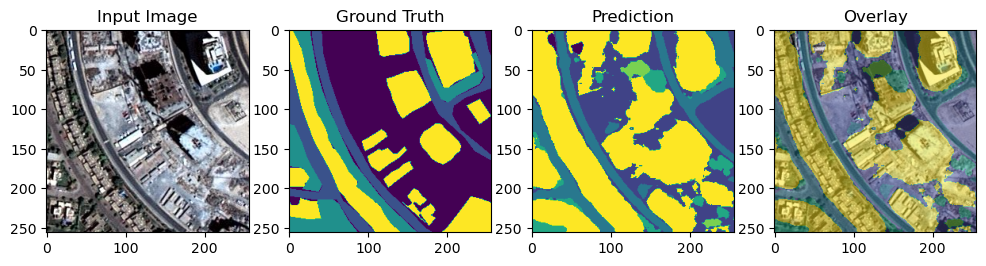

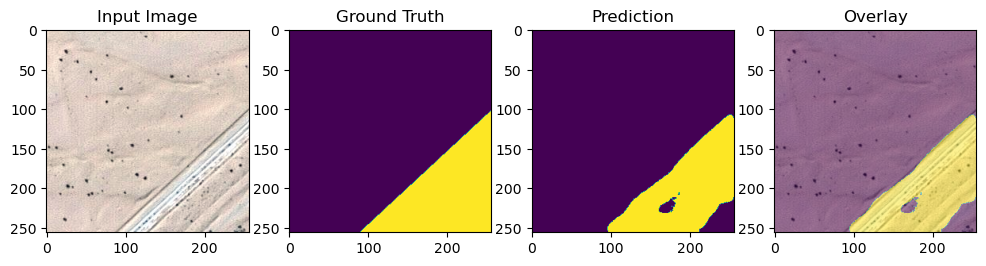

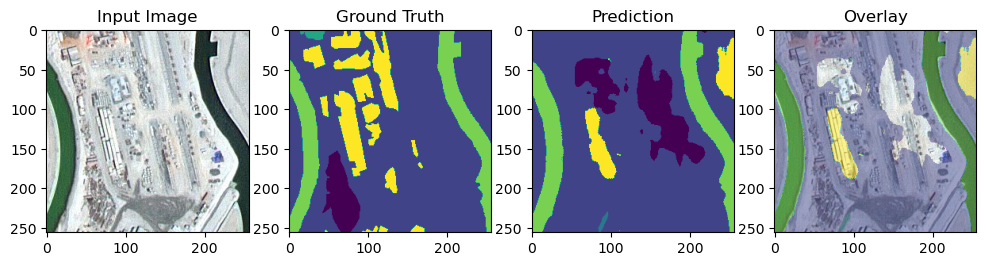

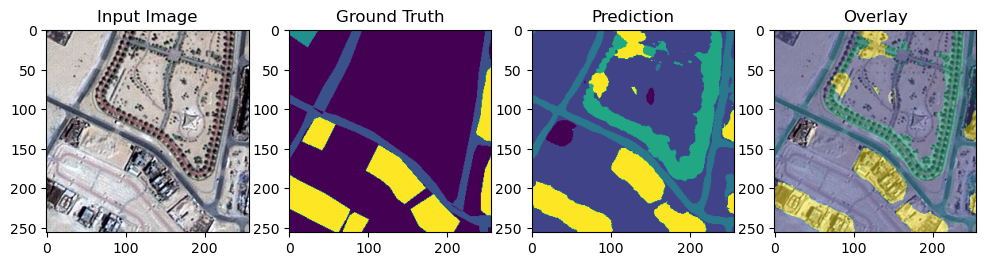

In [18]:
# predict new mask & plot results
def generate_plot():
    # get random image index
    rand_number = randint(0, len(X_test))
    test_img = X_test[rand_number]
    ground_truth = y_test_argmax[rand_number]
    
    # make prediction
    test_img_input = np.expand_dims(test_img, 0)
    prediction = unet_model.predict(test_img_input, verbose=0)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]
    
    # plot: input, mask, prediction, overlay
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    
    axs[0].imshow(test_img)
    axs[0].set(title='Input Image')
    
    axs[1].imshow(ground_truth)
    axs[1].set(title='Ground Truth')
    
    axs[2].imshow(predicted_img)
    axs[2].set(title='Prediction')
    
    axs[3].imshow(test_img)
    axs[3].imshow(predicted_img, alpha=0.5*(predicted_img > 0))
    axs[3].set(title='Overlay')
    
    plt.show()

# perform predictions
for _ in range(0, 4):
    generate_plot()

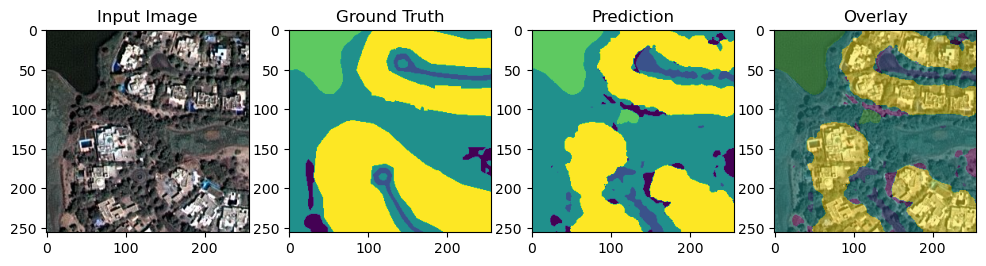

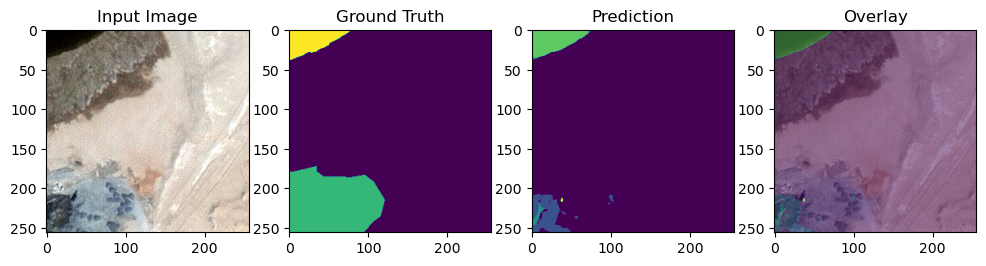

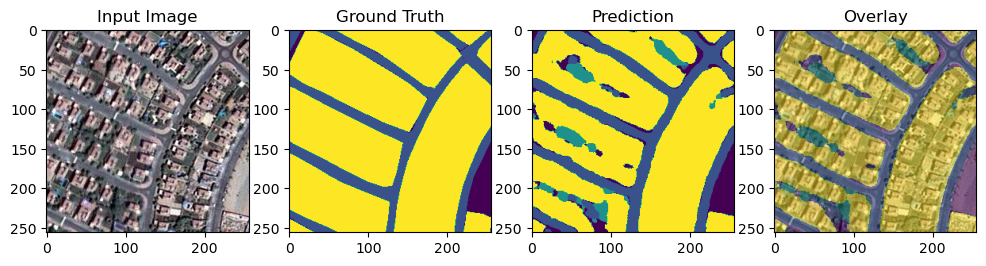

In [19]:
for _ in range(0, 3):
    generate_plot()

These predicted masks look quite accurate compared to the random inputs. Overall, our U-Net network segments the images and recognizes the classes correctly.

### 6. Conclusions

This notebook was developed to perform a semantic segmentation problem on satellite urban imagery of Dubai. An artificial neural network with U-Net architecture was built to complete this task. The learning process was monitored and evaluated with common image segmentation metrics: Jaccard index (IoU) and Dice index. The visual assessment of predicted and ground truth masks demonstrate fairly high accuracy and performance. The U-Net proved to serve as a foundational framework and to be highly effective in handling large-scale image datasets. The custom loss function, which was a combination of Dice loss and Focal loss, contributed to the model's robustness and accuracy, ensuring precise segmentation across multiple classes. The success of this project highlights the reliability of deep learning in land cover classification and segmentation.

**References**
* A. Géron, 2019, *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition*
* B.A. Khan, J.W. Jung, 2024, *Semantic Segmentation of Aerial Imagery Using U-Net with Self-Attention and Separable Convolutions*, [Full Text](https://www.mdpi.com/2076-3417/14/9/3712)
* K.D.M. De Silva, H.J. Lee, 2023, *Distorted Aerial Images Semantic Segmentation Method for Software-Based Analog Image Receivers Using Deep Combined Learning*, [Full Text](https://www.mdpi.com/2076-3417/13/11/6816)
* O. Ronneberger, P. Fischer, T. Brox, 2015, *U-Net: Convolutional Networks for Biomedical Image Segmentation*, [Full Text](https://arxiv.org/pdf/1505.04597)
* https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras.md [Accessed: 07.08.2024]
* https://newspaceeconomy.ca/2023/10/23/satellite-image-segmentation-from-land-cover-classification-to-segment-anything/ [Accessed: 07.08.2024]
* https://pub.aimind.so/satellite-imagery-segmentation-using-u-net-4ec7f265ddbe [Accessed: 07.08.2024]
* https://towardsdatascience.com/semantic-segmentation-of-aerial-imagery-using-u-net-in-python-552705238514 [Accessed: 07.08.2024]
* https://towardsdatascience.com/u-net-for-semantic-segmentation-on-unbalanced-aerial-imagery-3474fa1d3e56 [Accessed: 07.08.2024]